This notebook serves as a showcase for the functions written in the ``wwdata`` package, more specifically the OnlineSensorBased subclass. For additional information on the functions, the user is encouraged to use the provided docstrings. They can be accessed by entering a function name and hitting shift+tab between the function brackets.

All information and documentation on the ``wwdata`` package, including how to install it, can also be found online at https://ugentbiomath.github.io/wwdata-docs/.

An elaborate explanation on the functionalities of the package is accepted for publication in *Environmental Modelling and Software* and will soon be available on [ResearchGate](https://www.researchgate.net/project/Data-analysis-and-gap-filling).

# Loading the necessary packages

In [1]:
import sys
import os
from os import listdir
import pandas as pd
import scipy as sp
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn is not a required package, it just prettifies the figures
import seaborn as sns

And now for the actual package...

In [2]:
import wwdata as ww

Check what version you have installed

In [4]:
ww.__version__

'0.2.0'

# Reading data

In [5]:
measurements = pd.read_csv('./data/201301.txt',sep='\t',skiprows=0)
measurements.columns

Index(['Time', 'TSS_line3', 'NO3_line3', 'CODtot_line3', 'CODsol_line3',
       'TSS_line2', 'NO3_line2', 'CODtot_line2', 'CODsol_line2', 'TSS_line1',
       'NO3_line1', 'CODtot_line1', 'CODsol_line1', 'Cond_ns', 'Turb_ns',
       'Temp_ns', 'Ammonium_ns', 'Cond_es', 'Turb_es', 'Temp_es', 'NH4_infl',
       'NH3_line3', 'Turb_rz', 'Cond_rz', 'Temp_rz', 'PO4_mixinggutter',
       'TSS_efflPST', 'NO3_efflPST', 'CODtot_efflPST', 'CODsol_efflPST',
       'TSS_efflRBT', 'NO3_efflRBT', 'CODtot_efflRBT', 'CODsol_efflRBT',
       'Cond_line1', 'Turb_line1', 'Cond_line2', 'Turb_line2', 'Cond_line3',
       'Turb_line3', 'NH4_efflPST', 'PO4_efflPST', 'PO4_sandtrap',
       'NH4_splittingworks', 'PO4_splittingworks', 'Flow_line1', 'Flow_line2',
       'Flow_line3', 'Flow_total'],
      dtype='object')

# Create Class object and format data

In [6]:
dataset = ww.OnlineSensorBased(data=measurements,
                               timedata_column='Time',
                               data_type='WWTP')
dataset.set_tag('January 2013')
dataset.replace('Bad','NaN',inplace=True)

Convert the values in the column containing time data to the pandas datetime format.

In [7]:
dataset.to_datetime(time_column=dataset.timename,time_format='%d-%m-%y %H:%M')

use the time-column as index

In [8]:
dataset.set_index('Time',key_is_time=True,drop=True,inplace=True)

Convert the absolute timestamps to relative values. This can be important when data is to be used for modeling purposes later on, and needs to be written to text files.

In [9]:
#dataset.absolute_to_relative(time_data='index',unit='d')

Drop any duplicates that might be present in the index

In [10]:
dataset.drop_index_duplicates()

Convert all or the selected columns to float type.

In [11]:
dataset.to_float(columns='all')

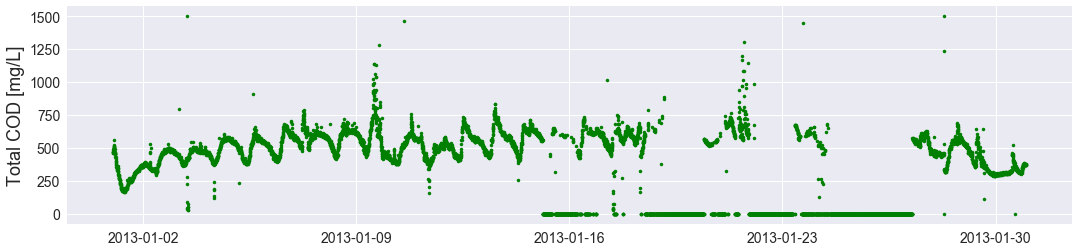

In [12]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(dataset.data['CODtot_line2'],'.g')
ax.set_ylabel('Total COD [mg/L]',fontsize=18);ax.set_xlabel('')
ax.tick_params(labelsize=14)

# Select data

Selecting data happens through tagging, so no original data is lost. When applying filter algorithms such as ``tag_doubles``, ``moving_slope_filter`` etc., a new pandas dataframe is created (``dataset.meta_valid``, see also below figure) that contains these tags. It is also based on this new dataframe that the plotting of selected and not selected datapoints in different colours happens.

![validation](./figs/packagestructure_validation.png)

The written output of the filter functions tells the user how many data points were tagged based on that specific function. When the plotting argument is set to true, the plot shows the aggregated results of the filter functions used up until that point.

## Maxima
Tag the data points that are higher then a certain percentile

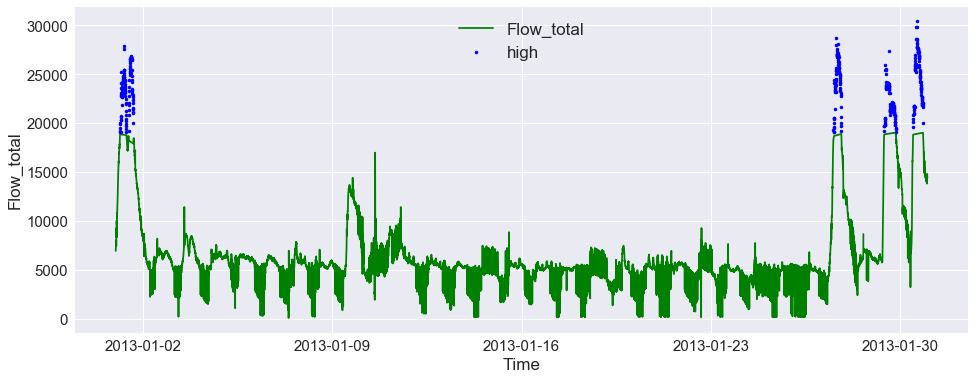

In [16]:
dataset.get_highs('Flow_total',0.95,arange=['2013/1/1','2013/2/1'],method='percentile',plot=True)

## NaN values
Tag all NaN (Not a Number) values as 'filtered'.

In [17]:
dataset.tag_nan('CODtot_line2')

47 values detected and tagged as filtered by function NaN tagging


## Sensor failure
Tag all datapoints that are part of a constant (within a given bound) signal.

In [18]:
dataset.tag_doubles('CODtot_line2',bound=0.05,plot=False)

2464 values detected and tagged as filtered by function double value tagging


## Noise 
Tag all data points for which the slope as compared with the previous point is too high to be realistic (i.e. the data point is noisy).

In [20]:
dataset.moving_slope_filter('index','CODtot_line2',72000,arange=['2013/1/1','2013/2/1'],
                            time_unit='d',inplace=False,plot=False)

199 values detected and tagged as filtered by function moving slope filter


Tag all data points that are more than a specified percentage away from the calculated moving average. This function makes use of the ``simple_moving_average`` function, also written as part of this package.

In [22]:
dataset.moving_average_filter(data_name='CODtot_line2',window=12,cutoff_frac=0.20,
                              arange=['2013/1/1','2013/2/1'],plot=False)

2810 values detected and tagged as filtered by function moving average filter


65.77546296296296% datapoints are left over from the original 8640.0


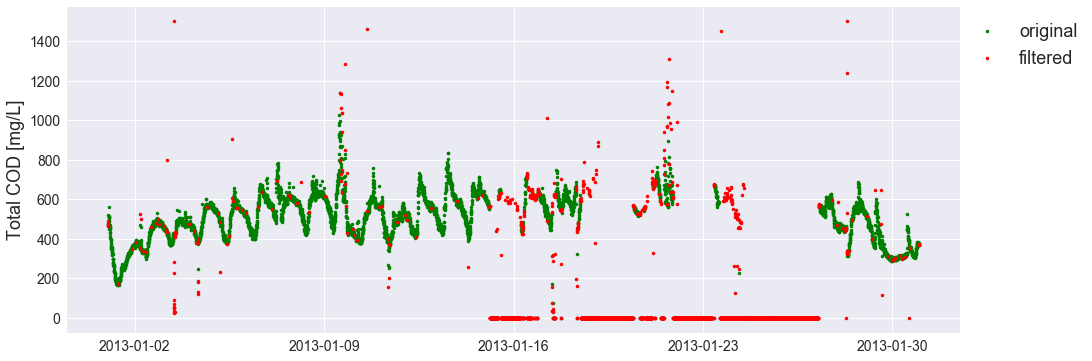

In [23]:
fig, ax = dataset.plot_analysed('CODtot_line2')
ax.legend(bbox_to_anchor=(1.15,1.0),fontsize=18)
ax.set_ylabel('Total COD [mg/L]',fontsize=18);ax.set_xlabel('')
ax.tick_params(labelsize=14)

In [25]:
dataset.columns

array(['TSS_line3', 'NO3_line3', 'CODtot_line3', 'CODsol_line3',
       'TSS_line2', 'NO3_line2', 'CODtot_line2', 'CODsol_line2',
       'TSS_line1', 'NO3_line1', 'CODtot_line1', 'CODsol_line1', 'Cond_ns',
       'Turb_ns', 'Temp_ns', 'Ammonium_ns', 'Cond_es', 'Turb_es',
       'Temp_es', 'NH4_infl', 'NH3_line3', 'Turb_rz', 'Cond_rz', 'Temp_rz',
       'PO4_mixinggutter', 'TSS_efflPST', 'NO3_efflPST', 'CODtot_efflPST',
       'CODsol_efflPST', 'TSS_efflRBT', 'NO3_efflRBT', 'CODtot_efflRBT',
       'CODsol_efflRBT', 'Cond_line1', 'Turb_line1', 'Cond_line2',
       'Turb_line2', 'Cond_line3', 'Turb_line3', 'NH4_efflPST',
       'PO4_efflPST', 'PO4_sandtrap', 'NH4_splittingworks',
       'PO4_splittingworks', 'Flow_line1', 'Flow_line2', 'Flow_line3',
       'Flow_total'], dtype=object)

Instead of a package-specific filtering, data points can also be filtered and replaced by other filtering algorithms, such as the Savitsky-Golay filter as illustrated below. The disadvantage of this is that no tags are added to the ``meta_valid`` DataFrame and that original data are replaced (when the ``inplace`` option is set to ``True``).

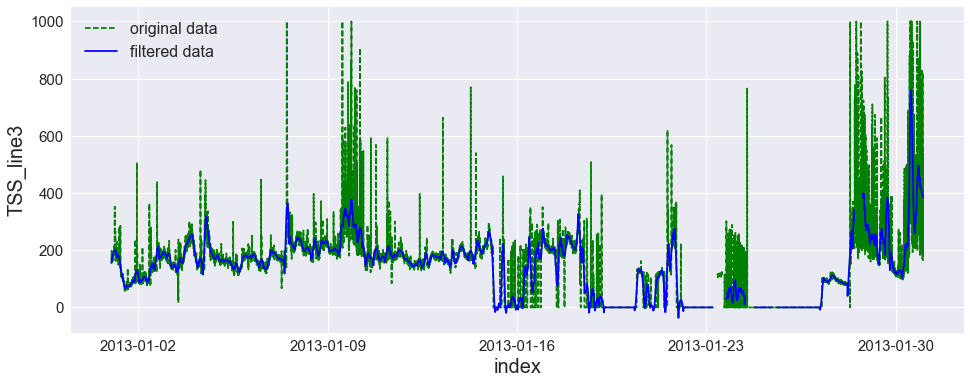

In [26]:
dataset.savgol('TSS_line3',plot=True)

# Fill data

Filling data can be done using a range of functions implemented in the package. Again, a new pandas dataframe is created (``dataset.meta_filled``, see also below figure), starting from the ``dataset.meta_valid`` dataframe, and updated with tags indicating what filling method was used to obtain a certain point.

Using the ``only_checked`` argument, implemented in most filling functions, the user can always choose whether only data points tagged as ``filtered`` will be used, or all data points within a certain range.

When using the plotting argument to plot the analysed data, the user will see a plot based on the latest function that was used; if this was a filter function, the data will be plotted based on the ``dataset.meta_valid`` dataframe, if it was a filling function, the tags in ``dataset.meta_filled`` will be used.

## Interpolation
Fill missing data points by interpolation, if number of consecutive missing points is lower than a specified number.

/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:283: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')
/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:326: UserWarning: Data points obtained during a rain event will be replaced. Make sure you are confident in this replacement method for the filling of gaps in the data during rain events.
  'filling of gaps in the data during rain events.')


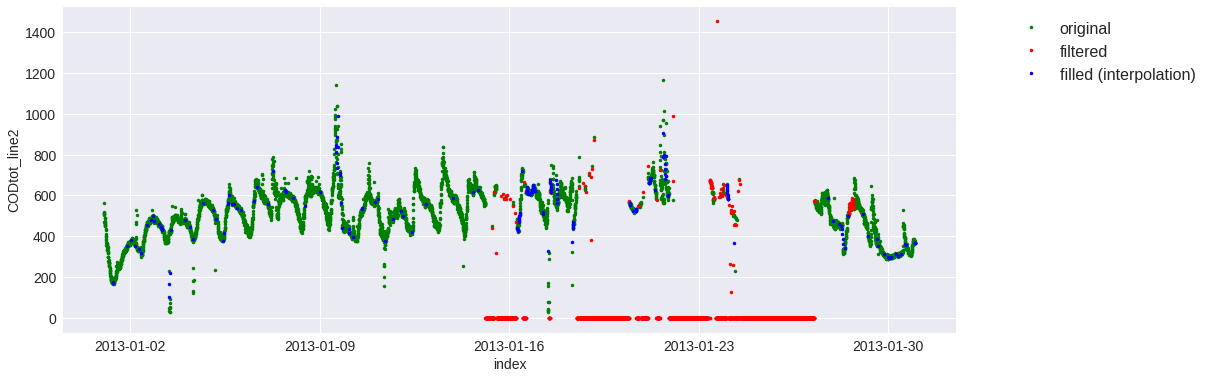

In [17]:
dataset.fill_missing_interpolation('CODtot_line2',12,[dt.datetime(2013,1,1),dt.datetime(2013,1,31)],
                                   plot=True)

## Average daily profile
Fill missing datapoints by using an average daily profile. The ``fill_missing_standard`` function requires the running of the ``calc_daily_profile`` function, also developed for this package, first. This creates a dataframe (``dataset.daily_profile``) containing the average daily profile calculated within a defined time period (e.g. selecting only non-peak days for example).

In [27]:
dataset.calc_daily_profile('CODtot_line2',[dt.datetime(2013,1,1),dt.datetime(2013,1,8)],
                           quantile=0.9,clear=True)

/Users/chaimdemulder/Documents/Work/github/wwdata/wwdata/Class_HydroData.py:1593: UserWarning: Data points obtained during a rain event will be used for the calculation of an average day. This might lead to a not-representative average day and/or high standard deviations.
  'representative average day and/or high standard deviations.')


/Users/chaimdemulder/Documents/Work/github/wwdata/wwdata/Class_OnlineSensorBased.py:667: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


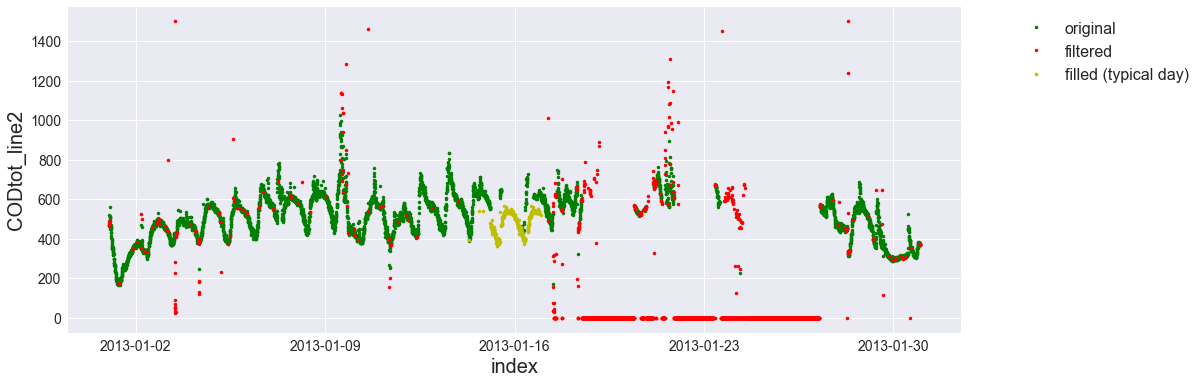

In [28]:
dataset.fill_missing_standard('CODtot_line2',[dt.datetime(2013,1,14),dt.datetime(2013,1,17)],
                              filtered_only=True,clear=False,plot=True)

## Model output
Fill gaps using a model output. This assumes that the user has good reason to trust that the model predictions are sound and can indeed be used to replace missing data where needed.

In [29]:
model_output_ontv_1 = pd.read_csv('./data/model_output.txt',
                           sep='\t')
units_model = model_output_ontv_1.ix[0]
model_output_ontv_1 = model_output_ontv_1.drop(0,inplace=False).reset_index(drop=True)
model_output_ontv_1 = model_output_ontv_1.astype(float)
model_output_ontv_1.set_index('#.t',drop=True,inplace=True)
model_output_ontv_1.columns

/Users/chaimdemulder/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['.sewer_1.COD', '.sewer_1.CODs', '.sewer_1.NH4', '.sewer_1.PO4',
       '.sewer_1.Q_DWF_UB', '.sewer_1.Q_in', '.sewer_1.TSS'],
      dtype='object')

/Users/chaimdemulder/Documents/Work/github/wwdata/wwdata/Class_OnlineSensorBased.py:803: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


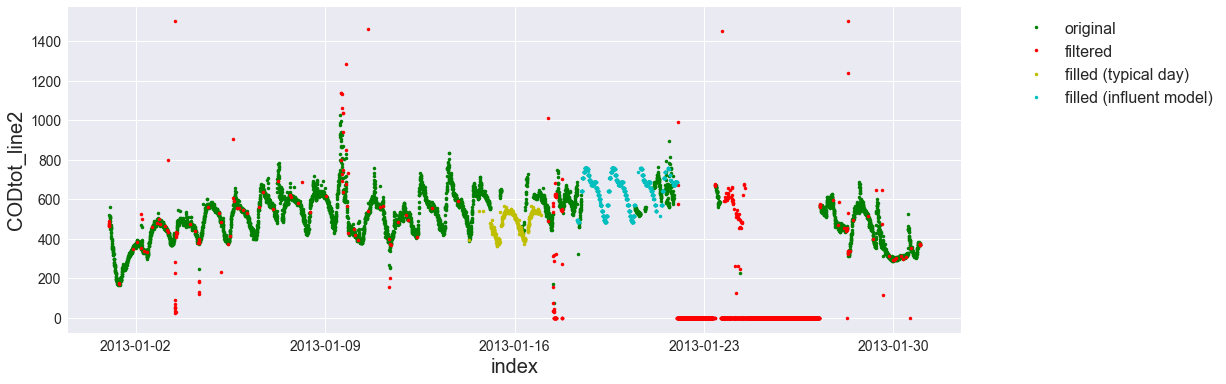

In [30]:
dataset.fill_missing_model('CODtot_line2',model_output_ontv_1['.sewer_1.COD'],
                           [dt.datetime(2013,1,18),dt.datetime(2013,1,22)],
                           filtered_only=True,plot=True)

## Ratio or correlation
Constant ratios or correlations between data can be used to filled missing points. The user can calculate and compare ratios and correlations (currently only linear) between selected measurements, and fill data using these.

*nb: in the examples below, data filling based on ratios or correlation is obviously not a very good choice. Both methods are included here for completeness of method showcasing.*

In [22]:
dataset.calc_ratio('CODtot_line2',
                   'CODsol_line2',
                   [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)])

(2.4506423271968965, 0.67215321408512652)

In [23]:
avg,std = dataset.compare_ratio('CODtot_line2',
                                'CODsol_line2',
                                2)

Best ratio (2.53282188261 ± 0.165864918725) was found in the range: [Timestamp('2013-01-19 00:05:00') Timestamp('2013-01-21 00:05:00')]


/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:407: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


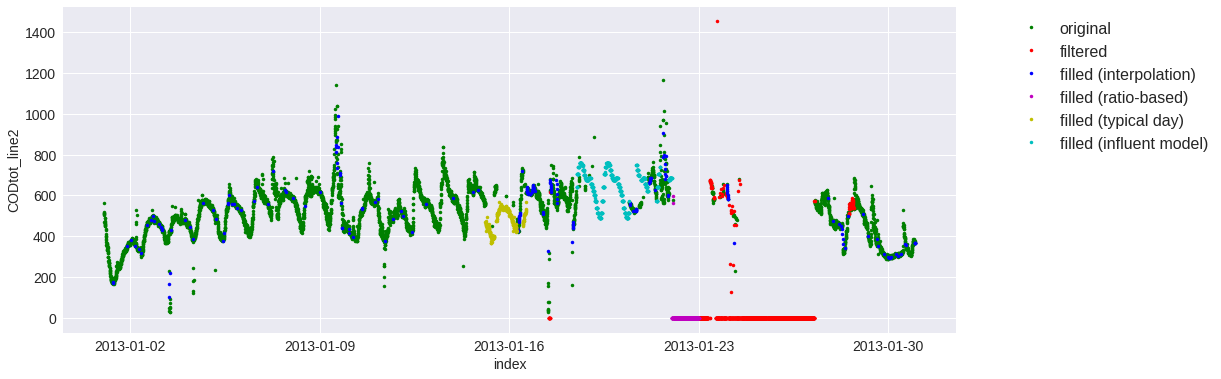

In [24]:
dataset.fill_missing_ratio('CODtot_line2',
                           'CODsol_line2',avg,
                           [dt.datetime(2013,1,22),dt.datetime(2013,1,23)],
                           filtered_only=True,plot=True)

(2.4013406142627947, 0, 0.97377465637633953)

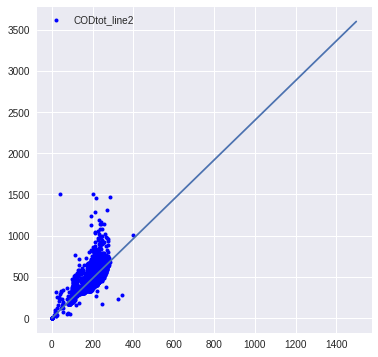

In [25]:
dataset.get_correlation('CODtot_line2',
                        'CODsol_line2',
                        [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)],
                        zero_intercept=True,plot=True)

/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:514: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


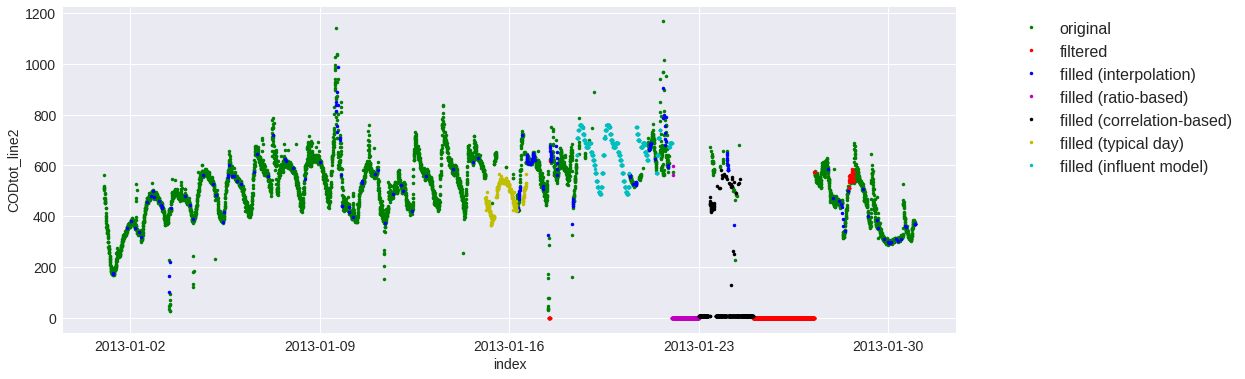

In [26]:
dataset.fill_missing_correlation('CODtot_line2',
                                 'CODsol_line2',
                                 [dt.datetime(2013,1,23),dt.datetime(2013,1,25)],
                                 [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)],
                                 filtered_only=True,clear=False,plot=True)

## Data from previous day
Under the assumption that "The best prediction for tomorrows weather is todays weather", one can also replace missing data by making use of (one of) the previous days.

/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:902: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


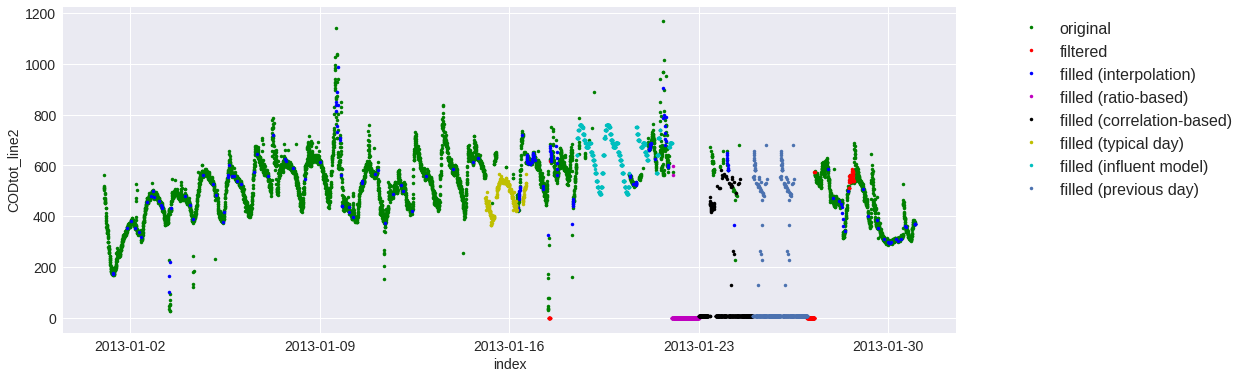

In [27]:
dataset.fill_missing_daybefore('CODtot_line2',
                               [dt.datetime(2013,1,25),dt.datetime(2013,1,27)],
                               range_to_replace=[0,10],plot=True,
                               filtered_only=False)

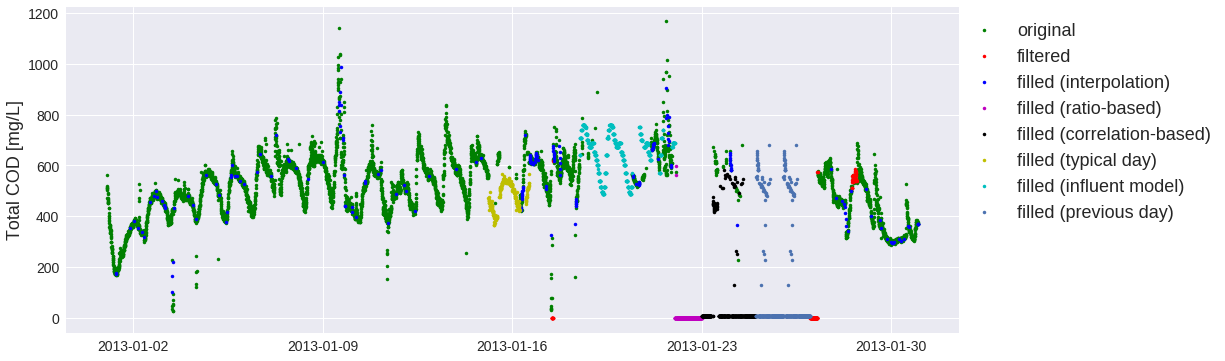

In [28]:
fig, ax = dataset.plot_analysed('CODtot_line2')
ax.legend(bbox_to_anchor=(1.3,1.0),fontsize=18)
ax.set_ylabel('Total COD [mg/L]',fontsize=18);ax.set_xlabel('')
ax.tick_params(labelsize=14)

# Calculations

Calculate the daily average of a certain data series

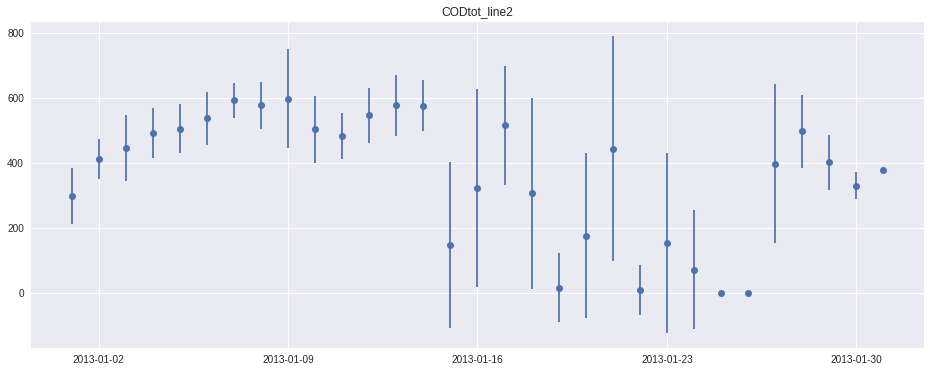

In [29]:
averages = dataset.calc_daily_average('CODtot_line2',plot=True)

Calculate the proportional concentration of different flows coming together.

In [30]:
dataset.calc_total_proportional('Flow_total',
                                ['Flow_line1','Flow_line2','Flow_line3'],
                                ['TSS_line1','TSS_line2','TSS_line3'],
                               'TSS_prop')

/home/data/cpdmulde/Documents/GitHub/wwdata/wwdata/Class_OnlineSensorBased.py:155: UserWarning: Something might have gone wrong with the updating of the units. Check self.units to make sure everything is still okay.
  'Check self.units to make sure everything is still okay.')


In [31]:
#dataset.write_to_WEST('test.txt','test_WEST.txt',units)